In [1]:
import torch
import torch.nn.functional as F
import numpy as np

from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm

from dataloader import *

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Our code
from trainer import POCMLTrainer
from model import POCML, sim
from visualizer import * 

# Setting random seed for consistent behavior
import random
train_seed = 72 - 3
random.seed(train_seed)
torch.manual_seed(train_seed)
torch.cuda.manual_seed(train_seed)
torch.backends.cudnn.deterministic = True
random.seed(train_seed)
np.random.seed(train_seed)

# Environment & Data Configuration

In [2]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 9
n_obs = 9
trajectory_length = 12  # numer of node visits in a trajectory
num_desired_trajectories= 20

env = GraphEnv( n_items=n_nodes,                     # number of possible observations
                env='grid', 
                batch_size=trajectory_length, 
                num_desired_trajectories=num_desired_trajectories, 
                device=None, 
                unique=True,                         # each state is assigned a unique observation if true
                args = {"rows": 3, "cols": 3}
            )

#dataset = RandomWalkDataset(env.adj_matrix, trajectory_length, num_desired_trajectories, n_obs, env.items)
train_dataset = env.dataset.data

env.gen_dataset()
test_dataset = env.dataset.data

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Set config & hyperparameter pools for wandb

In [3]:
# Convention: for each hyperparameter key, set the value to a list if you want to try multiple values
param_pool = {  
    # data-related config; can't be automated for now
    "n_obs" : env.n_items,
    "n_states" : env.size,
    "n_actions" : env.n_actions,
    # model 
    "state_dim" : 500,
    "random_feature_dim" : [1000, 2000],
    "alpha" : 1,
    "beta_obs" : 8,
    "beta_state" : 8,
    "memory_bypass" : False,
    "mem_reweight_rate" : "adaptive", 
    "decay" : "adaptive",
    # trainer
    "lr_Q_o" : 0.1, 
    "lr_V_o" : 0.01, 
    "lr_Q_s" : 0., 
    "lr_V_s" : 0., 
    "lr_all" : 1,
    "normalize" : False,
    "reset_every" : 4,
    "refactor_memory" : True,
    "epochs" : 10
}

In [4]:
import itertools

def generate_combinations_loader(param_pool):
    keys, values = zip(*[
        (k, v if isinstance(v, list) else [v])
        for k, v in param_pool.items()
    ])
    for combination in itertools.product(*values):
        yield dict(zip(keys, combination))

# Use the loader to generate combinations one at a time
param_loader = generate_combinations_loader(param_pool)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


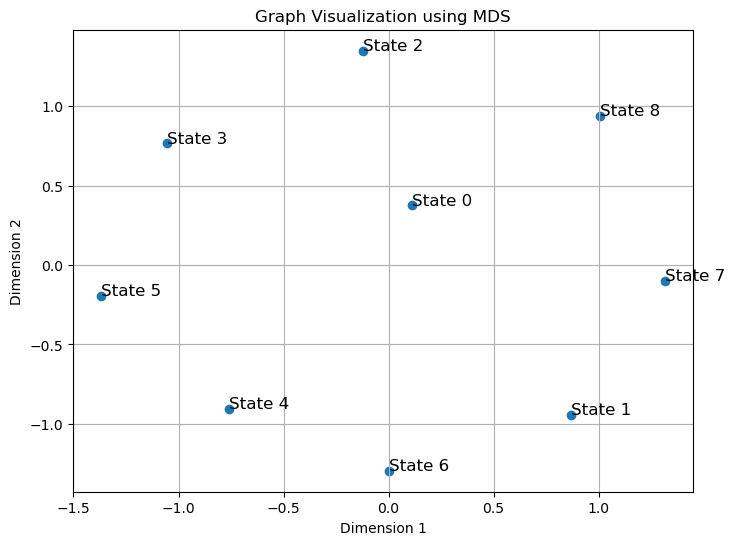

/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


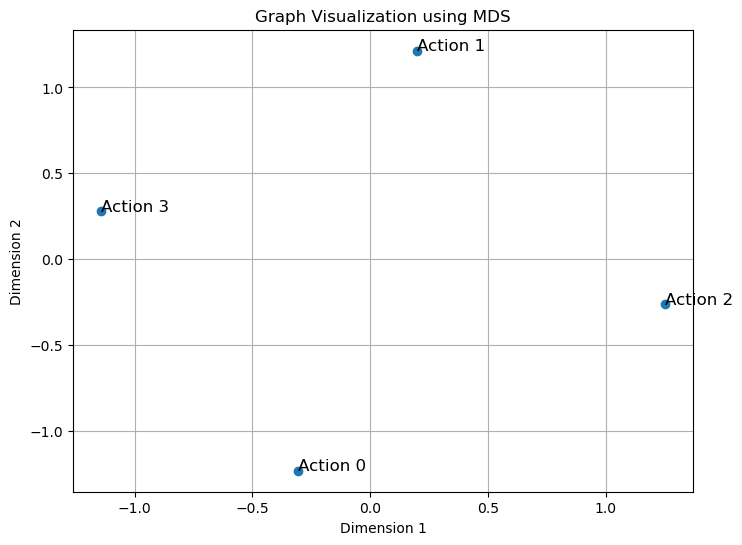

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


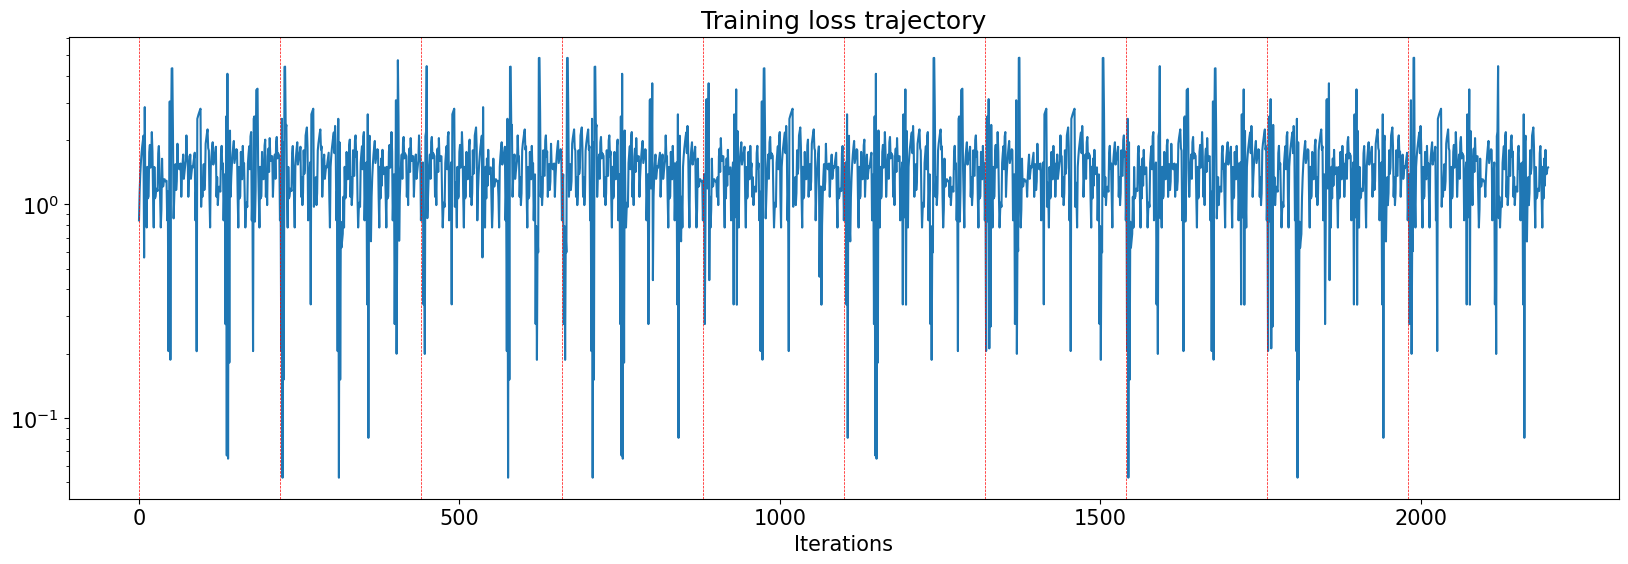

In [5]:
from inspect import signature

def filter_param(param: dict, obj) -> dict:
    init_params = signature(obj).parameters
    return {k: v for k, v in param.items() if k in init_params}

for params in param_loader:

    # Filter parameters to match the model & trainer's __init__ signature
    trainer_params = filter_param(params, POCMLTrainer)
    model_params = filter_param(params, POCML)

    # Instantiate the model & trainer using the filtered dictionary
    model = POCML(**model_params)
    trainer = POCMLTrainer(model = model, train_loader = train_dataloader, **trainer_params)
    loss_record = np.array(trainer.train(params["epochs"])).reshape(params["epochs"],-1)

    visualize(model.get_state_differences().numpy(), legend = "State")
    visualize(model.get_action_differences().numpy(), "Action")
    visualize_loss(loss_record, num_desired_trajectories, trajectory_length, per_epoch=False)
    visualize_loss(loss_record, num_desired_trajectories, trajectory_length, per_epoch=True)


In [ ]:
def wandb_run()

In [5]:
phi_Q = model.get_state_kernel()
phi_V = model.get_action_kernel()
print("State kernel similarities:\n", sim(phi_Q.T, phi_Q.T))
print("Action kernel similarities:\n", sim(phi_V.T, phi_V.T))

State kernel similarities:
 tensor([[1.0000, 0.3700, 0.4026, 0.3944, 0.3645, 0.3685, 0.3888, 0.3627, 0.3777],
        [0.3700, 1.0000, 0.3854, 0.3794, 0.3914, 0.3770, 0.3798, 0.3904, 0.3798],
        [0.4026, 0.3854, 1.0000, 0.3621, 0.3512, 0.3890, 0.3953, 0.3660, 0.3825],
        [0.3944, 0.3794, 0.3621, 1.0000, 0.3713, 0.3982, 0.3723, 0.3878, 0.3714],
        [0.3645, 0.3914, 0.3512, 0.3713, 1.0000, 0.3824, 0.3811, 0.3920, 0.4120],
        [0.3685, 0.3770, 0.3890, 0.3982, 0.3824, 1.0000, 0.3918, 0.3717, 0.3658],
        [0.3888, 0.3798, 0.3953, 0.3723, 0.3811, 0.3918, 1.0000, 0.3686, 0.3586],
        [0.3627, 0.3904, 0.3660, 0.3878, 0.3920, 0.3717, 0.3686, 1.0000, 0.4036],
        [0.3777, 0.3798, 0.3825, 0.3714, 0.4120, 0.3658, 0.3586, 0.4036, 1.0000]])
Action kernel similarities:
 tensor([[1.0000, 0.3439, 0.3407, 0.3772],
        [0.3439, 1.0000, 0.3307, 0.4033],
        [0.3407, 0.3307, 1.0000, 0.3440],
        [0.3772, 0.4033, 0.3440, 1.0000]])


In [6]:
# beta_obs, beta_state, clean up rate
torch.save(model.state_dict(), "model/model_12_12_1.ckpt")

In [7]:
import evaluate

train_acc, train_confidences = evaluate.accuracy(model, train_dataloader)
print("Train obs accuracy/confidence:", train_acc, np.mean(train_confidences))

test_acc, test_confidences = evaluate.accuracy(model, test_dataloader)
print("Test obs accuracy/confidence:", test_acc, np.mean(test_confidences))

sa_acc, sa_confidences, sa_distance_ratios = evaluate.state_transition_consistency(model, env)
print("State-action accuracy/confidence/distance ratio:", sa_acc, np.mean(sa_confidences), np.mean(sa_distance_ratios))

Train obs accuracy/confidence: 0.11363636363636363 0.10652958660979163
Test obs accuracy/confidence: 0.16363636363636364 0.112638737837022
State-action accuracy/confidence/distance ratio: 0.0 0.03672215947881341 1.2320083663673647


/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


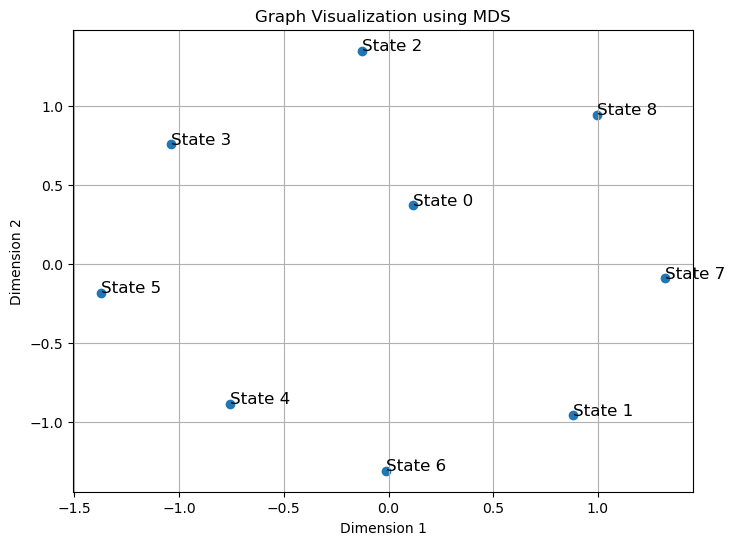

In [9]:
visualize(model.get_state_differences().numpy(), legend = "State")
visualize(model.get_action_differences().numpy(), "Action")

/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


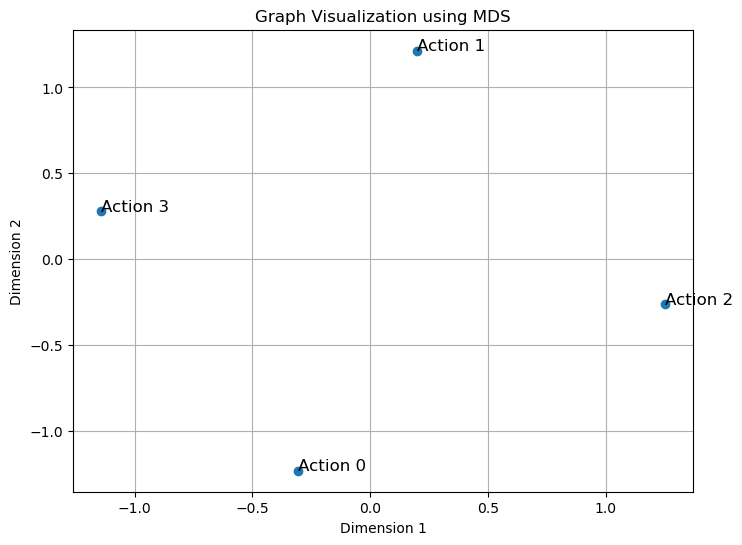

Text(0.5, 0, 'Epochs')

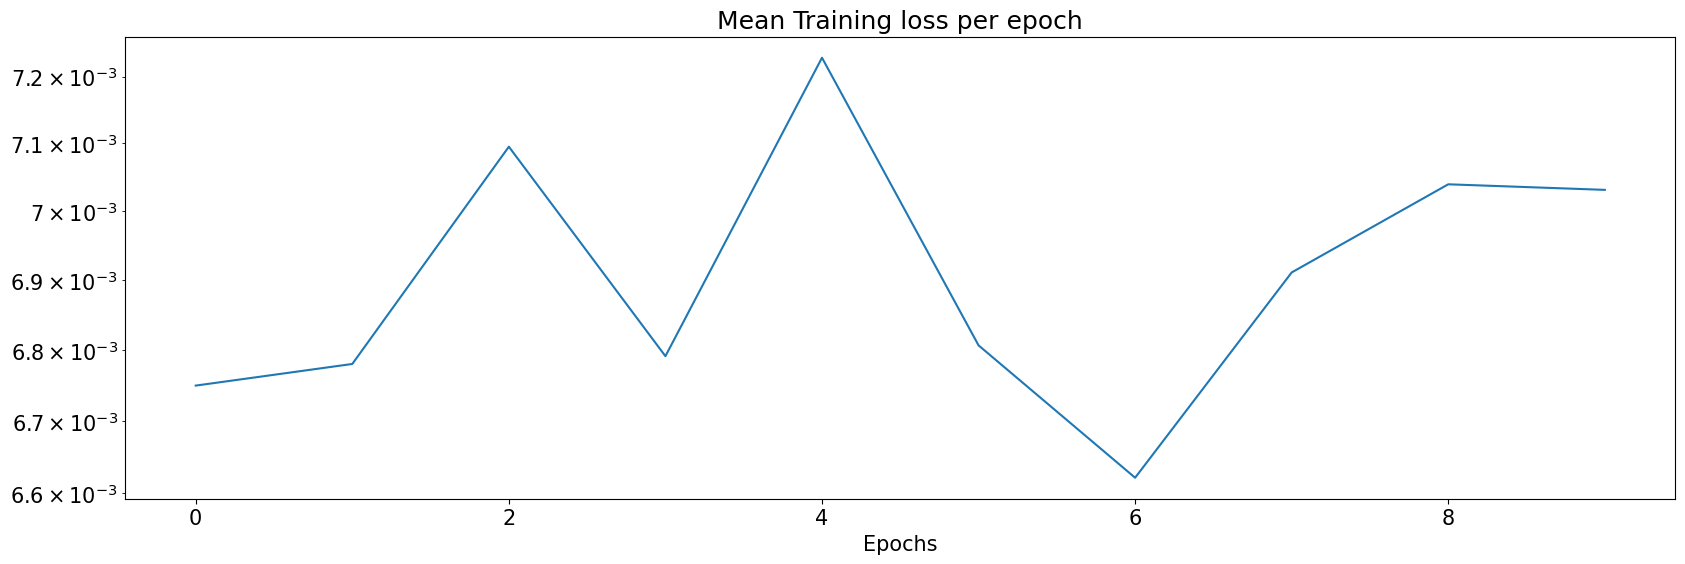

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


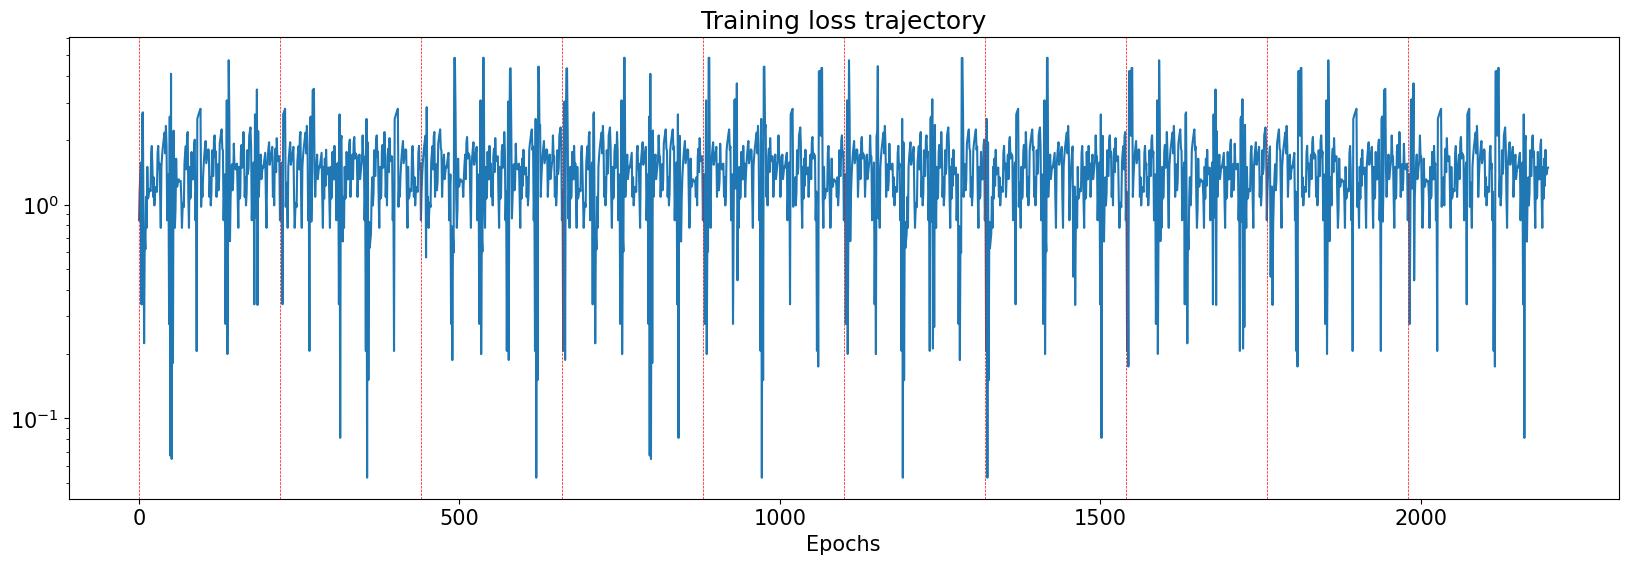

In [12]:
# our trainer loss plot - flattened 



In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            #steps, o_record = model.plan(start_idx, goal_idx, env, False)
            steps = model.plan(state, affordance=None):

        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:
# CML's model

def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_matrix(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 